주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [48]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np
import time

In [2]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

os.chdir("/content/drive/MyDrive/Data/Assignment/[0207]_Dimensionality Reduction")

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.chdir("/content/drive/MyDrive/Data/Assignment/[0209]_Clustering")

In [7]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('marketing_campaign.csv', sep = ';')

data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 데이터 전처리

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [35]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d"))

data.Dt_Customer = pd.to_datetime(data['Dt_Customer'])

data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype('int')

data['days'][:5]

0    3813
1    3263
2    3462
3    3289
4    3311
Name: days, dtype: int64

In [36]:
## 나이를 age에 저장
data['age'] = 2024 - data['Year_Birth']

data['age'][:5]

0    67
1    70
2    59
3    40
4    43
Name: age, dtype: int64

In [39]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis = 1)

data['CampaignAttendance'][:5]
## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

0    0
1    0
2    0
3    0
4    0
Name: CampaignAttendance, dtype: int64

In [41]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [42]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [47]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_features)

X_features_scaling = scaler.transform(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling , columns = X_features.columns, index = list(X_features.index.values))

X_features_scaling[:5]

,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1.529129,0.986443,0.234063,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,0.693232,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,2.377952
1,-1.188411,1.236801,-0.234559,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2,-0.205155,0.318822,0.769478,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,-0.543978,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
3,-1.059945,-1.266777,-1.017239,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,0.280829,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
4,-0.951244,-1.016420,0.240221,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530


###차원 축소

데이터를 차원 축소 해봅시다.

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
start = time.time()
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

print('소요시간 : ' , f'{time.time()-start:.4f}sec')

소요시간 :  0.0454sec


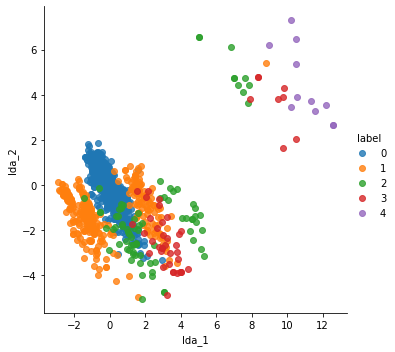

In [50]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [51]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

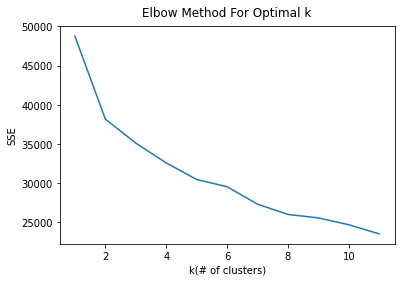

In [53]:
## Elbow method의 x값은 군집 수, y값은 원하는 지표 (내부평가) 사용이 가능합니다.
# 가장 구현이 간편한 SSE를 내부 평가 지표로 삼아 구현해봅시다.

sse = []
K = range(1, 12)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(X_features_scaling)
  sse.append(km.inertia_)

plt.plot(K, sse)
plt.xlabel('k(# of clusters)')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k', pad = 10)
plt.show()

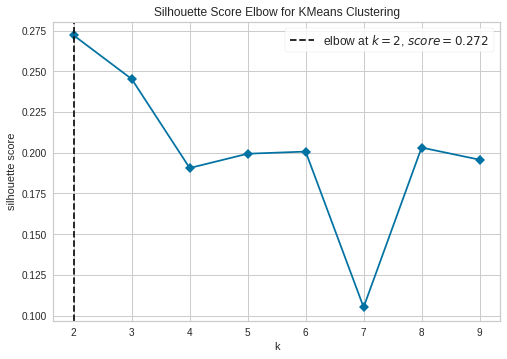

In [61]:
from yellowbrick.cluster import KElbowVisualizer

elbowvisualizer = KElbowVisualizer(KMeans(), k = (2,10), metric = 'silhouette', timings = False)

elbowvisualizer.fit(X_features_scaling)  
elbowvisualizer.show()

In [54]:
## 클러스터 수는 ########(숫자)########로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 2)

y_km = km.fit_predict(X_features_scaling)

y_km

array([1, 0, 1, ..., 1, 1, 0], dtype=int32)

In [55]:
X_train_lda['K_means'] = y_km

####시각화

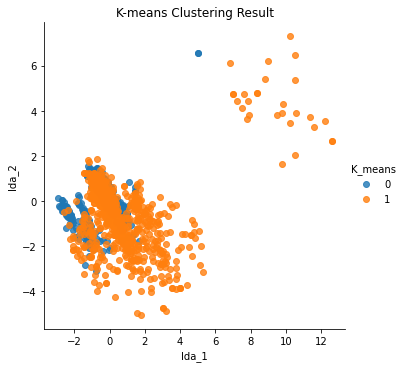

In [56]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')

plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [62]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [63]:
## 클러스터 수는 ########(숫자)########로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.
y_agghc = agghc.fit_predict(X_features_scaling)

y_agghc

array([0, 1, 0, ..., 1, 0, 1])

In [64]:
X_train_lda['hierarchical'] = y_agghc

####시각화

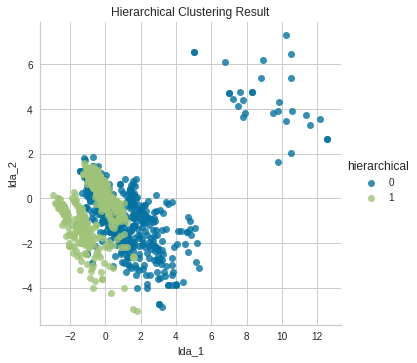

In [65]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')

plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [68]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN
import sklearn.utils
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors

In [69]:
nb = NearestNeighbors(n_neighbors = 4).fit(X_features_scaling)

In [70]:
minPts = 4

In [71]:
#kneighbors([X, n_neighbors, return_distance]): Find the K-neighbors of a point.
distances, indices = nb.kneighbors(X_features_scaling)

In [72]:
distances #한 점이 minPts를 만족하는 점들과의 거리

array([[1.19209290e-07, 3.34668520e+00, 3.52977034e+00, 3.53985459e+00],
       [0.00000000e+00, 9.09903423e-01, 9.39336054e-01, 9.58490843e-01],
       [0.00000000e+00, 1.63108673e+00, 1.92351889e+00, 2.01634054e+00],
       ...,
       [0.00000000e+00, 2.85466117e+00, 3.02415529e+00, 3.27335510e+00],
       [0.00000000e+00, 1.42852458e+00, 1.70955064e+00, 1.75579970e+00],
       [0.00000000e+00, 1.14949383e+00, 1.40752549e+00, 1.54215594e+00]])

In [73]:
indices #해당 점에 대해 minPts를 만족하는 점들의 index

array([[   0, 1177, 1911, 2137],
       [   1, 1869, 1615, 1563],
       [   2,  549, 1107, 1390],
       ...,
       [2213, 1630, 1236, 1262],
       [2214, 1107, 1550, 1390],
       [2215, 1569, 1392, 1946]])

minPts번째 점에 해당하는 거리를 내림차순으로 정렬하여 k-dist graph를 그립니다.

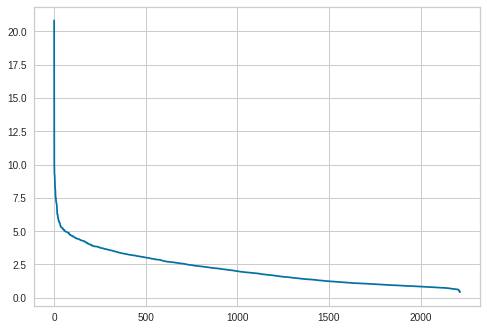

In [76]:
distance = sorted(distances[:, minPts-1], reverse = True)

plt.plot(list(range(0,2216)), distance)

In [80]:
## eps는 ########(숫자)########, minPts는 ########(숫자)########로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 0.5, min_samples = 4, metric = 'euclidean') #eps는 0-1
y_dbscan = dbscan.fit_predict(X_features_scaling)

y_dbscan

array([-1, -1, -1, ..., -1, -1, -1])

In [81]:
X_train_lda['dbscan'] = y_dbscan

X_train_lda['dbscan']

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
2211   -1
2212   -1
2213   -1
2214   -1
2215   -1
Name: dbscan, Length: 2216, dtype: int64

####시각화

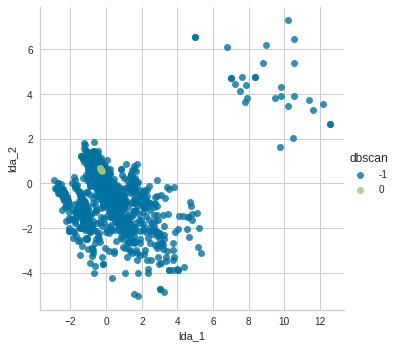

In [82]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)

plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

Hierarchical Clustering이 가장 성능이 좋아보이며 DBSCAN이 가장 성능이 낮아보임.



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [83]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [84]:
coef_km = metrics.silhouette_score(X_features_scaling, y_km)

print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.2720303244969593.


Hierarchical Clustering의 실루엣 계수입니다.

In [85]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.24392857890655703.


DBSCAN의 실루엣 계수입니다.

In [86]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling, y_dbscan)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is -0.2255937075525873.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

K-Means Klustering > Hierarchical Clustering > DBSCAN

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

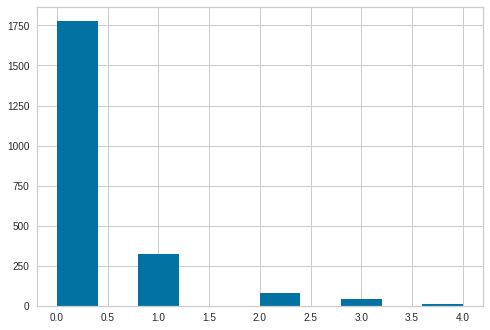

In [87]:
plt.hist(data['CampaignAttendance'])

plt.show()

> 실루엣 계수는 각각의 데이터가 해당 데이터와 같은 군집 내의 데이터와는 얼마나 가깝게 군집화가 되었고, 다른 군집에 있는 데이터와는 얼마나 멀리 분포되어 있는지를 나타내는 지표이며 1에 가까울수록 군집화가 잘 되었음을 의미한다.



> K-Means Klustering , Hierarchical Clustering , DBSCAN의 실루엣 계수를 확인해 보았을 때 모두 0.3을 넘지 않는 것으로 보아 Clustering이 잘 되지 않은 것으로 파악된다.


> 실루엣 계수를 활용한 elbow method를 통해 최적의 k가 2라고 판단하였으나 적절하지 않은 것이 원인인 것 같다.



(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

########(의견)########